<center>

# <font size="6" color="darkblue">Trabalho Laboratorial 1</font>

<br><br>

## <font size="4" color="black">Instituto Superior de Engenharia de Lisboa</font>

### Aprendizagem Automática

#### Docente: G. Marques

<br>

#### Realizado por:

<p style="text-align: center;"><font size="3">Belarmino Rafael Sacate nº: 52057</font></p>

<p style="text-align: center;"><font size="3">Miguel Ferreira nº: 51878</font></p>

<br><br>

#### Data: 01 de Novembro de 2025

<br><br><br>

</center>

---

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_recall_curve

---

# Introdução

Neste trabalho utiliza-se o *Pima Indians Diabetes Dataset* para a predição da presença de diabetes em mulheres da tribo Pima, uma população indígena do sudoeste dos Estados Unidos da América sujeita a elevada incidência da doença. Este conjunto de dados, recolhido pelo Instituto Nacional de Diabetes e Doenças Digestivas e Renais desde 1965, compreende 768 amostras de 8 características clínicas (tais como o número de gravidezes, a concentração de glicose plasmática e o índice de massa corporal), distribuídas por 500 casos negativos e 268 positivos, o que configura um problema de classificação binária desequilibrado.

Aplicam-se três classificadores binários: o *RandomForestClassifier* (um ensemble de árvores de decisão robusto ao ruído e ao desequilíbrio de classes, obrigatório pelo enunciado), o *K-Nearest Neighbors* (KNN, baseado em similaridade local e sensível à escala das features) e a *Logistic Regression* (um modelo linear probabilístico, interpretável e eficiente computacionalmente). Além disso, investiga-se o impacto da normalização dos dados (mediante o *StandardScaler*, que transforma cada dimensão para média nula e variância unitária) no desempenho dos modelos, uma vez que algoritmos como o KNN e a Logistic Regression beneficiam de *features* escaladas uniformemente, enquanto que o *Random Forest* revela-se menos afetado.

Os objetivos centrais consistem na formação e avaliação dos classificadores, na otimização de hiperparâmetros e na sua comparação atravéz de métricas como *accuracy*, *precisão*, *recall*, *F1-score* e *ROC-AUC*.

---

### Leitura dos Dados

Ao fazer a leitura e vizualização dos dados do dataset fornecido (pimaDiabetes.p), constata-se que o mesmo possui duas classes, das quais, a primeira (0) representa os casos de pessoas sem diabetes, e a segunda, os casos de pessoas com diabetes. Neste dataset, cada indivíduo tem 8 características, associadas à sua condição médica.

In [3]:
fName1 = "pimaDiabetes.p"
D = pickle.load(open(fName1, 'rb')) 

X.shape:  (768, 8)
y.shape:  (768,)
Número de exemplos positivos (diabetes): 268
Número de exemplos negativos (sem diabetes): 500
Número de Características:  8
Número de Pessoas:  768
Características:  ['Number of times pregnant', 'Plasma glucose concentration at 2 Hours in an oral glucose tolerance test (GTIT)', 'Diastolic Blood Pressure (mm Hg)', 'Triceps skin fold thickness (mm)', '2-Hour Serum insulin (µh/ml)', 'Body mass index [weight in kg/(Height in m)]', 'Diabetes pedigree function', 'Age (years)']
500 mulheres sem diabetes (0) e 268 com diabetes (1)


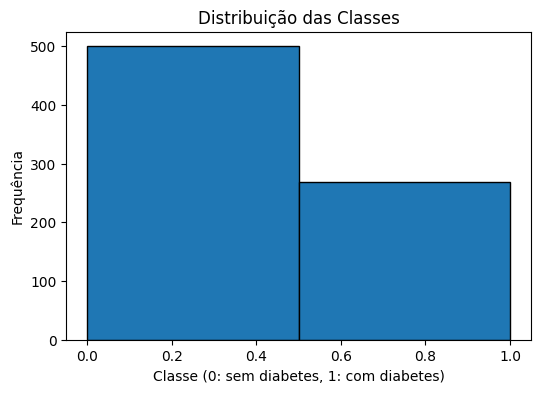

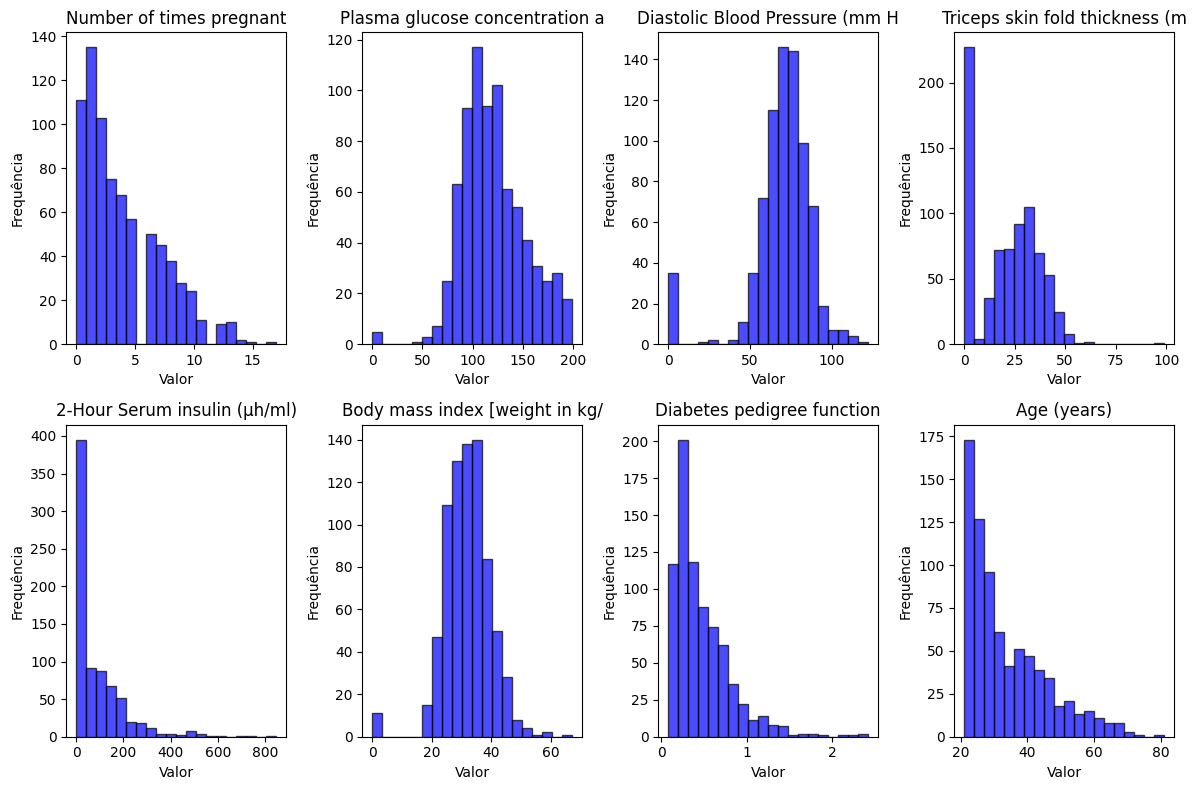

In [4]:
X = D['data']
y = D['target']
feature_names = D['feature_names']

print("X.shape: ", X.shape)
print("y.shape: ",y.shape)
print("Número de exemplos positivos (diabetes):", np.sum(y)) 
print("Número de exemplos negativos (sem diabetes):", np.sum(y == 0))
print("Número de Características: ", len(feature_names))
print("Número de Pessoas: ", len(y))
print("Características: ", feature_names)
print("500 mulheres sem diabetes (0) e 268 com diabetes (1)")

# Visualizar distribuição das classes (histograma)
plt.figure(figsize=(6, 4))
plt.hist(y, bins=2, edgecolor='black')
plt.xlabel('Classe (0: sem diabetes, 1: com diabetes)')
plt.ylabel('Frequência')
plt.title('Distribuição das Classes')
plt.show()
plt.figure(figsize=(12, 8))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.hist(X[:, i], bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title(feature_names[i][:30])  # primeiros 30 caracteres do nome
    plt.xlabel('Valor')
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

----

### Treino e Teste dos Dados

Separação dos dados em treino e teste recorrendo ao uso da função *train_test_split* onde foram utilizados os parametros *test_size=1/3* guarda um terço dos dados para teste e o restante para treino, o *stratify=y* mantêm a proporção das classes de treino e teste, finalmente o *random_state=42* introduz aleatoridade aos dados, no entanto, mantêm a possibilidade de reproduzir os resultados.

In [5]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, stratify=y, random_state=42)
prporcap_positivos_treino = np.sum(y_train) / len(y_train)
prporcap_positivos_teste = np.sum(y_test) / len(y_test)

print("Proporção positivos no treino: ", prporcap_positivos_treino)
print("Proporção positivos no teste: ", prporcap_positivos_teste)

Proporção positivos no treino:  0.349609375
Proporção positivos no teste:  0.34765625


---

# Função Principal

A função avaliação tem o objetivo de avaliar os resultados e desempenho de um classificador para um limiar de sensibilidade definido, calibrando o classificador na tentativa de reduzir Falsos Negativos.

Para ilustrar estes resultados é utilizado uma visualização da matriz de confusão, que mostra os acertos e erros, bem como, o desempenho do classificador através do classification_report. Este mostra as métricas principais: 
- accuracy: proporção de previsões certas em relação ao número total de casos


- precision: percetagem de classificações positivas corretas, ou seja, das previsões positivas, quais realmente é que são positivas.


- recall: percentagem de casos positivos que foram corretamente classificados (*True Positive Rate*)


De seguida, as curvas ROC e a métrica AUC, que permitem avaliar o desempenho do classificador para limiares de decisao diferentes, e conseguir ver a qualidade geral do modelo.

In [6]:
def avaliacao(model, X_test, y_test, threshold):

    print("-----------------------------------------------------------------------")
    print("\nAvaliação do modelo com threshold =", threshold)
    print("\n-----------------------------------------------------------------------")

    # PROBABILIDADES - diabetes[1]
    y_test_dec = model.predict_proba(X_test)[:, 1]
    
    # THRESHOLD
    y_pred_threshold = (y_test_dec >= threshold).astype(int)
    
    # MATRIZ DE CONFUSÃO COM THRESHOLD
    cm_threshold = confusion_matrix(y_test, y_pred_threshold)
    print(cm_threshold)
    
    # DISPLAY
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm_threshold)
    cmd.plot(cmap='Blues')
    plt.title('Matriz de Confusão com threshold')
    plt.show()
    
    # CLASSIFICATION REPORT
    print("Relatório de Classificação com threshold")
    print(classification_report(y_test, y_pred_threshold))
    
    # FALSE POSITIVE RATE E TRUE POSITIVE RATE NO PONTO ÓTIMO
    TN, FP = cm_threshold[0]
    FN, TP = cm_threshold[1]
    fpr_opt = FP / (FP + TN)
    tpr_opt = TP / (TP + FN)
    
    # CURVA ROC
    fpr, tpr, _ = roc_curve(y_test, y_test_dec)
    auc = roc_auc_score(y_test, y_test_dec)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot(fpr_opt, tpr_opt, 'o', markersize=8, label='Ponto ótimo')
    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.title('Curva ROC (Dados Escalados)')
    plt.grid(True, alpha=0.3)
    plt.axis('scaled')
    plt.legend()
    plt.show()
    
    # CURVA PRECISÃO-RECALL
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_dec)
    idx = np.argmin(np.abs(thresholds - threshold))
    recall_point = recall[idx]
    precision_point = precision[idx]
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision)
    plt.plot(recall_point, precision_point, 'or', alpha=0.2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Curva Precisão Recall (>= {threshold})")
    plt.axis([0,1,0,1])
    plt.grid(True)
    plt.show()

----

### LogisticRegression

O LogisticRegression é um classificador baseado em discriminantes lineares e usa uma função logística para saber a probabilidade de um exemplo pertencer a uma classe. Este algoritmo cria uma fronteira de decisão linear entre duas classes e é bastante útil quando existe uma separação linear e clara entre as classes.

Primeiramente, foi aplicada a normalização dos dados usando o *StandardScaler* que transforma cada dimensão para média nula e variância unitária. Este pré-processamento é aplicado com o *fit_transform* e é importante porque garante que o classificador corra normalmente, mesmo quando as características associadas a cada pessoa tenham uma escala diferente.

De seguida, utilizou-se o hiper-parâmetro *max_iter=5000* que define o número máximo de iterações durante o treino do classificador, possibilitanto que o algoritmo encontre uma solução ótima, e *random_state=42* que garante a possibilidade de reprodução dos resultados.

Por fim, usou-se a função *avaliacao* para calibrar o classificador com um limiar de decisão específico, otimizado por tentativa-erro.Assim, obtem-se os resultados calibrados e o desempenho do classificador através da matriz de confusão, das métricas de classificação e das Curvas ROC e Precisão-Recall.


Matriz de Confusão apos o treino
[[141  26]
 [ 41  48]]
Erros totais: 67

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       167
           1       0.65      0.54      0.59        89

    accuracy                           0.74       256
   macro avg       0.71      0.69      0.70       256
weighted avg       0.73      0.74      0.73       256

-----------------------------------------------------------------------

Avaliação do modelo com threshold = 0.3

-----------------------------------------------------------------------
[[117  50]
 [ 18  71]]


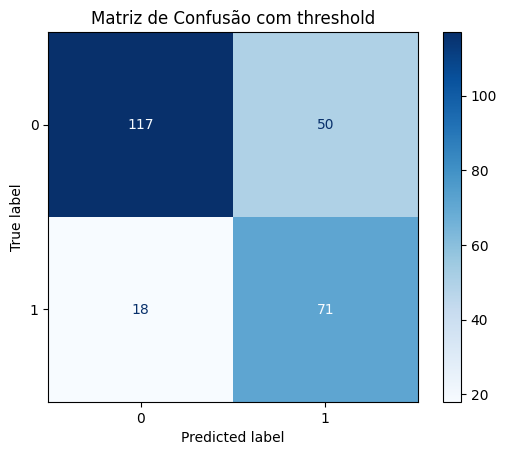

Relatório de Classificação com threshold
              precision    recall  f1-score   support

           0       0.87      0.70      0.77       167
           1       0.59      0.80      0.68        89

    accuracy                           0.73       256
   macro avg       0.73      0.75      0.73       256
weighted avg       0.77      0.73      0.74       256



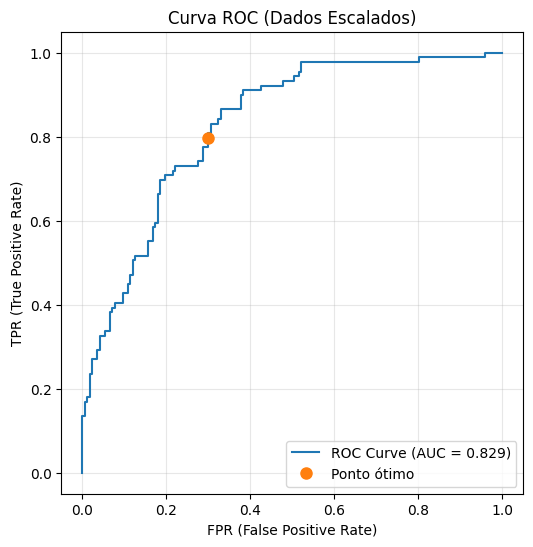

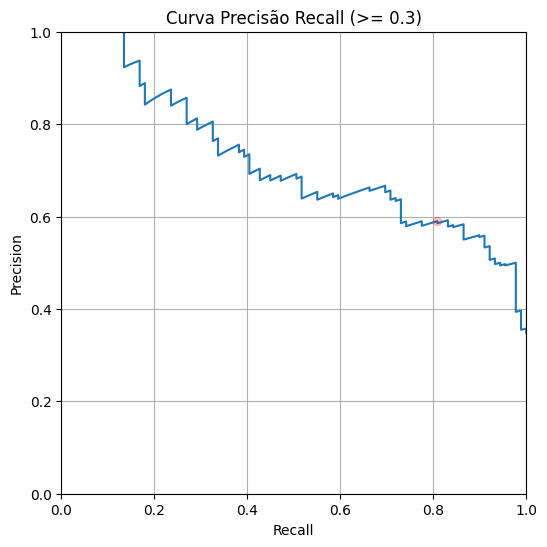

In [7]:
# Normalizacao dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr_scaled = LogisticRegression(max_iter=5000, random_state=42).fit(X_train_scaled, y_train)

# Matriz de confusao e report
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
print("\nMatriz de Confusão apos o treino")
print(confusion_matrix(y_test, y_test_pred_scaled))
erros = np.sum(y_test != y_test_pred_scaled)
print("Erros totais:", erros)
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_test_pred_scaled))

#avaliacao com threshold 0.3
avaliacao(lr_scaled, X_test_scaled, y_test, 0.3)

---

# RandomForestClassifier

O classificador RandomForest é baseado em ensemble que combina múltiplas árvores de decisão para melhorar as suas previsões. Neste caso, utilizou-se o hiper-parâmetro n_estimators=100 que define o número de árvores a construir, e random_state=42 para garantir a reprodutibilidade dos resultados.

Ao contrário da regressão logística, o RandomForest não requer normalização prévia dos dados, pois as árvores de decisão são invariantes à escala das características. Desta forma, o classificador foi treinado diretamente com os dados originais, utilizando o método fit.

Após o treino, foi realizada a avaliação do modelo através da análise da matriz de confusão e do classification_report, que apresentam as métricas de desempenho: acertos, erros e as métricas principais (accuracy, precision e recall). Por fim, utilizou-se a função avaliacao para calibrar o classificador com um limiar de decisão de 0.35, otimizado por tentativa-erro, permitindo obter os resultados calibrados e o desempenho do classificador através da matriz de confusão, das métricas de classificação e das curvas ROC e Precisão-Recall.

In [8]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler


Matriz de Confusão: 
[[137  30]
 [ 37  52]]

Acertos: 189 de 256
Erros: 67 de 256

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       167
           1       0.63      0.58      0.61        89

    accuracy                           0.74       256
   macro avg       0.71      0.70      0.71       256
weighted avg       0.73      0.74      0.74       256

-----------------------------------------------------------------------

Avaliação do modelo com threshold = 0.35

-----------------------------------------------------------------------
[[116  51]
 [ 20  69]]


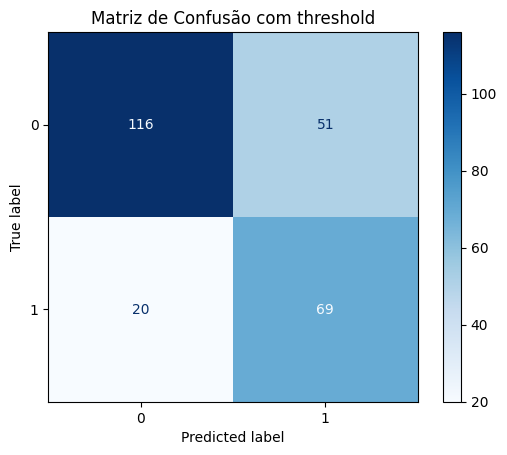

Relatório de Classificação com threshold
              precision    recall  f1-score   support

           0       0.85      0.69      0.77       167
           1       0.57      0.78      0.66        89

    accuracy                           0.72       256
   macro avg       0.71      0.73      0.71       256
weighted avg       0.76      0.72      0.73       256



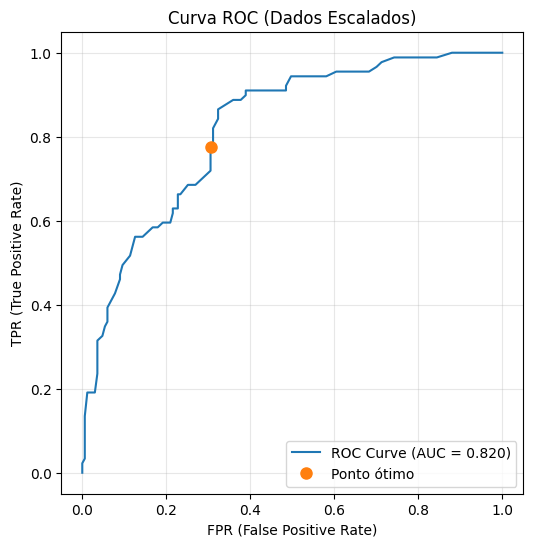

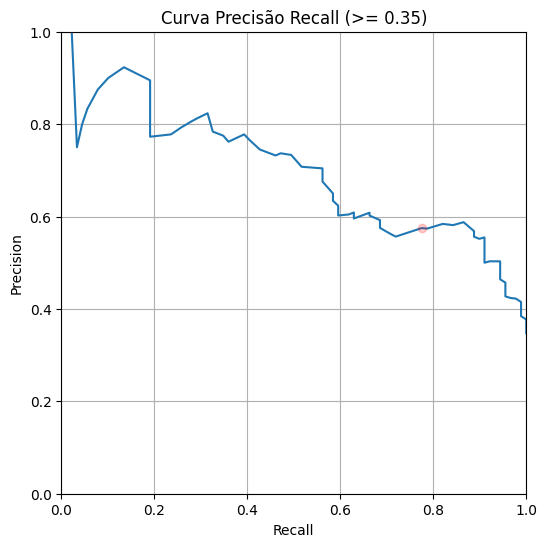

In [9]:
# A normalização dos dados não afeta o classificador 
# porque usa comparações baseadas em árvores e não a escala dos dados

# sc = StandardScaler().fit(X_train)       
# X_train = sc.transform(X_train)   
# X_test = sc.transform(X_test) 

# Treinar
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Estimar
ye = rfc.predict(X_test)

# Matriz de Confusão
MC = confusion_matrix(y_test, ye)
print("\nMatriz de Confusão: ")
print(MC)

# Resultados
print(f"\nAcertos: {np.sum(y_test == ye)} de {len(y_test)}")
print(f"Erros: {np.sum(y_test != ye)} de {len(y_test)}")

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, ye))

#Avaliaçao
avaliacao(rfc, X_test, y_test, 0.35)

# [TN, FP]
# [FN, TP]

In [10]:
# Testes para reduzir os falsos negativos (FN)

# matriz de Confusão
# print(f"\nMatriz de Confusão:")
# print(MC)

# # diabetes [1]
# y_prob = rfc.predict_proba(X_test)[:, 1]

# print("\nTeste 1: ")
# print(confusion_matrix(y_test, y_prob>=0.3))

# print("\nTeste 2: ")
# print(confusion_matrix(y_test, y_prob>=0.5))

# print("\nTeste 3: ")
# print(confusion_matrix(y_test, y_prob>=0.7))

# print("\nTeste 4: ")
# print(confusion_matrix(y_test, y_prob>=0.9))

# print("\nTeste 5: ")
# print(confusion_matrix(y_test, y_prob>=1))

# print("\nTeste 6: ")
# print(confusion_matrix(y_test, y_prob>=0.2))

# print("\nTeste 7: ")
# print(confusion_matrix(y_test, y_prob>=0.31))

# print("\nTeste 8: ")
# print(confusion_matrix(y_test, y_prob>=0.33))

# print("\nTeste 9: ")
# print(confusion_matrix(y_test, y_prob>=0.35))

# print("\nTeste 10: ")
# print(confusion_matrix(y_test, y_prob>=0.37))

# print("\nTeste 11: ")
# print(confusion_matrix(y_test, y_prob>=0.39))

# [TN, FP]
# [FN, TP]


---

# K-Neighbors

In [11]:
from sklearn.neighbors import KNeighborsClassifier


-----------------------------------------------------------------------
K-Neighbors:  3

Matriz de Confusão: 
[[134  33]
 [ 48  41]]


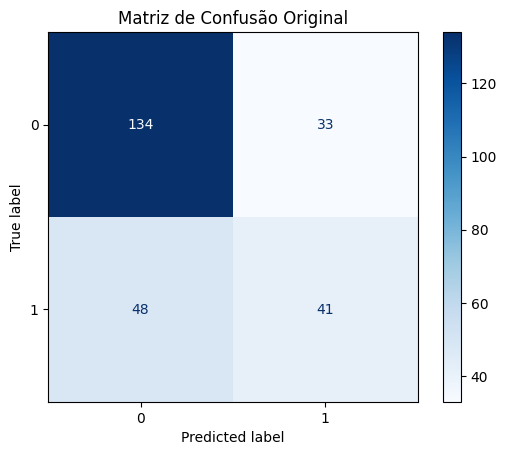


Acertos:  175  de  256
Erros:  81  de  256

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       167
           1       0.55      0.46      0.50        89

    accuracy                           0.68       256
   macro avg       0.65      0.63      0.64       256
weighted avg       0.67      0.68      0.68       256

-----------------------------------------------------------------------

Avaliação do modelo com threshold = 0.2

-----------------------------------------------------------------------
[[98 69]
 [16 73]]


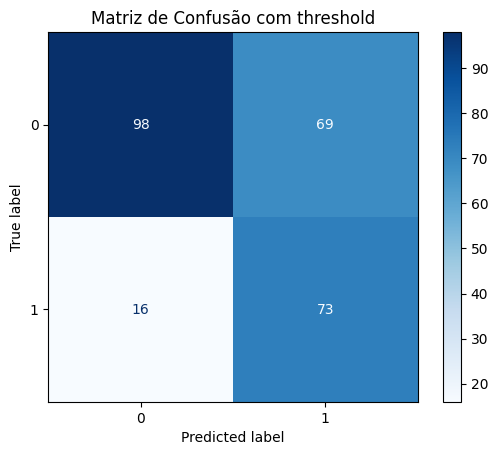

Relatório de Classificação com threshold
              precision    recall  f1-score   support

           0       0.86      0.59      0.70       167
           1       0.51      0.82      0.63        89

    accuracy                           0.67       256
   macro avg       0.69      0.70      0.66       256
weighted avg       0.74      0.67      0.67       256



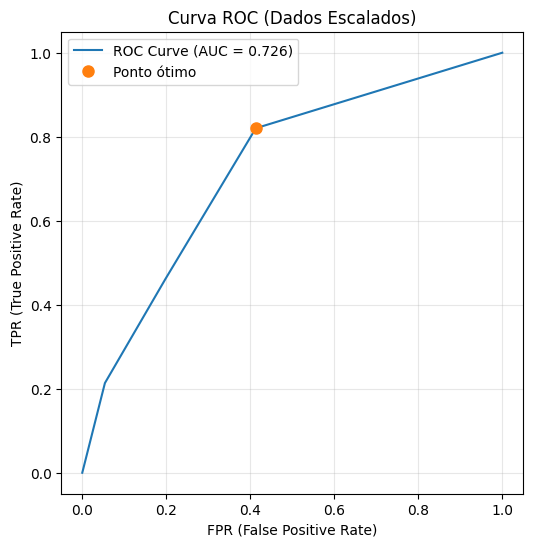

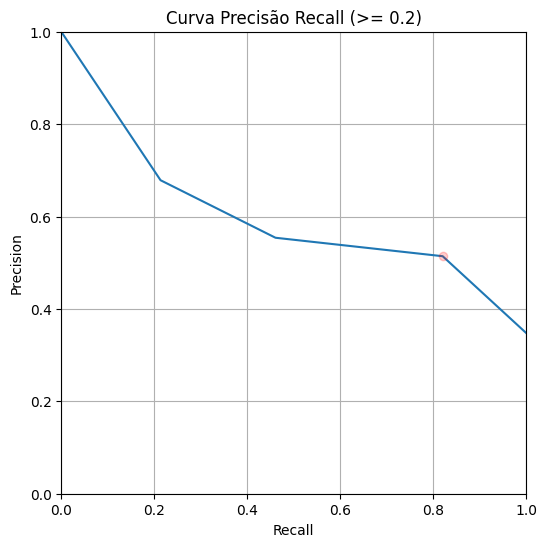


-----------------------------------------------------------------------
K-Neighbors:  5

Matriz de Confusão: 
[[141  26]
 [ 42  47]]


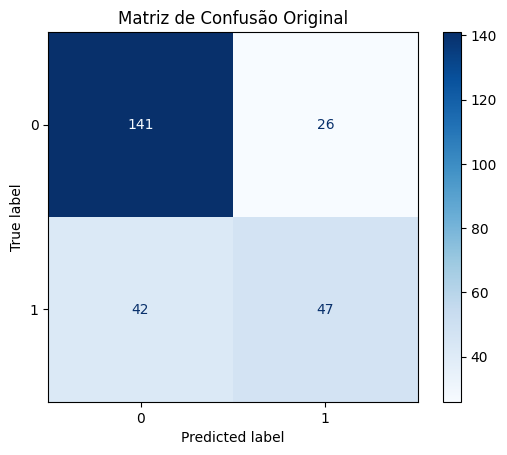


Acertos:  188  de  256
Erros:  68  de  256

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       167
           1       0.64      0.53      0.58        89

    accuracy                           0.73       256
   macro avg       0.71      0.69      0.69       256
weighted avg       0.73      0.73      0.73       256

-----------------------------------------------------------------------

Avaliação do modelo com threshold = 0.3

-----------------------------------------------------------------------
[[114  53]
 [ 25  64]]


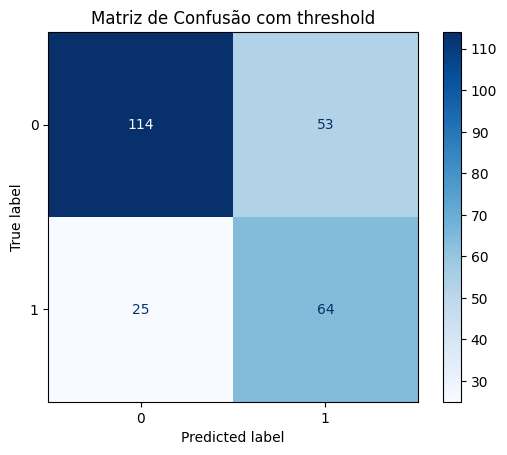

Relatório de Classificação com threshold
              precision    recall  f1-score   support

           0       0.82      0.68      0.75       167
           1       0.55      0.72      0.62        89

    accuracy                           0.70       256
   macro avg       0.68      0.70      0.68       256
weighted avg       0.73      0.70      0.70       256



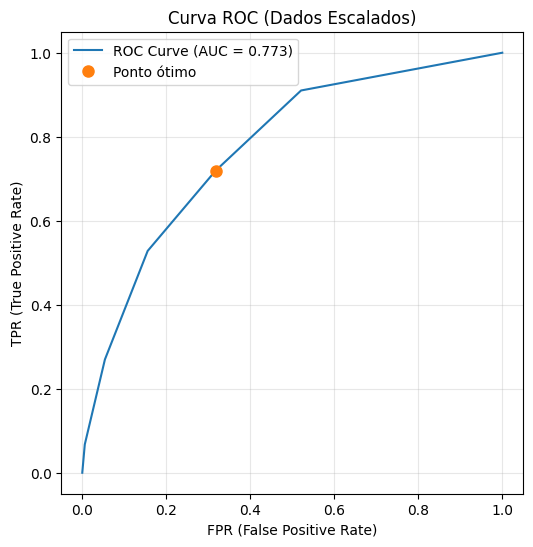

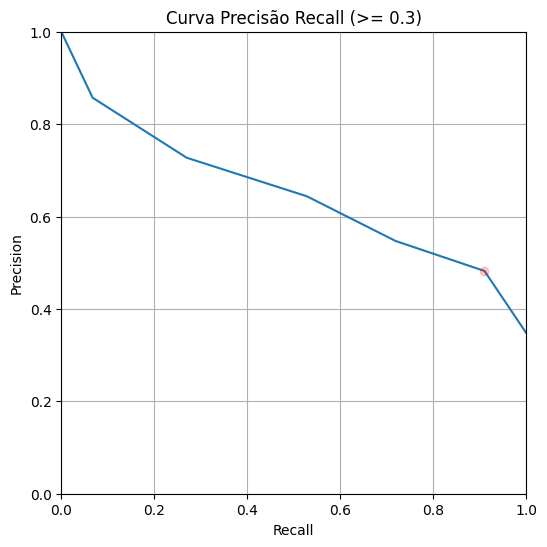


-----------------------------------------------------------------------
K-Neighbors:  7

Matriz de Confusão: 
[[143  24]
 [ 38  51]]


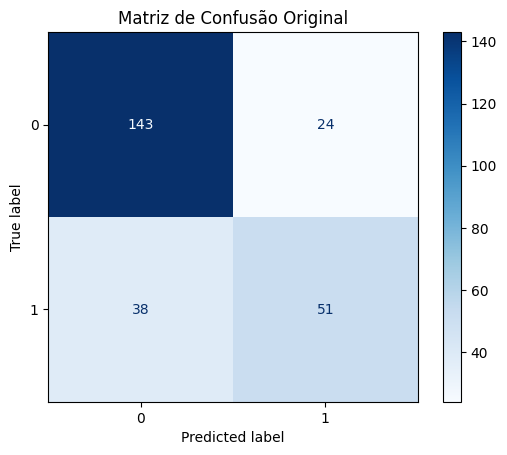


Acertos:  194  de  256
Erros:  62  de  256

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       167
           1       0.68      0.57      0.62        89

    accuracy                           0.76       256
   macro avg       0.74      0.71      0.72       256
weighted avg       0.75      0.76      0.75       256

-----------------------------------------------------------------------

Avaliação do modelo com threshold = 0.2

-----------------------------------------------------------------------
[[97 70]
 [16 73]]


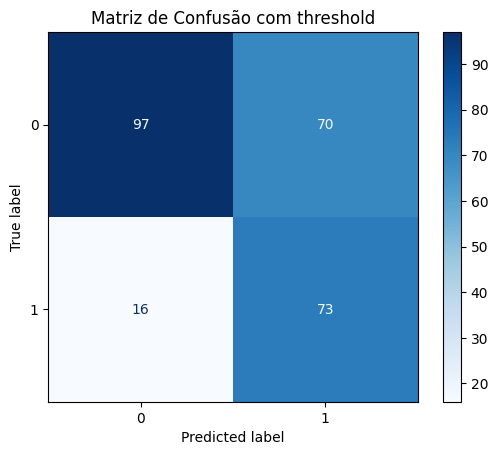

Relatório de Classificação com threshold
              precision    recall  f1-score   support

           0       0.86      0.58      0.69       167
           1       0.51      0.82      0.63        89

    accuracy                           0.66       256
   macro avg       0.68      0.70      0.66       256
weighted avg       0.74      0.66      0.67       256



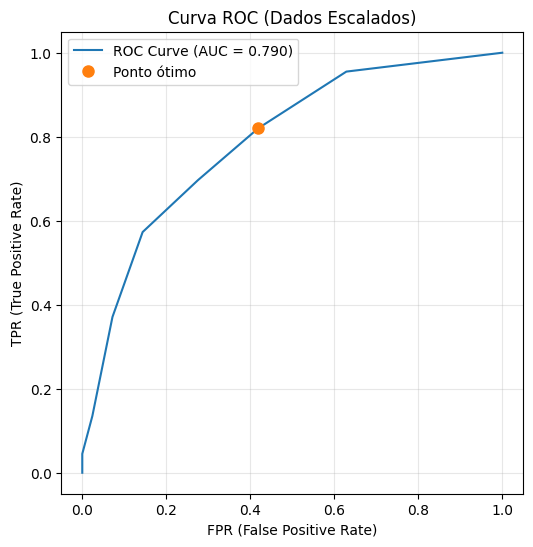

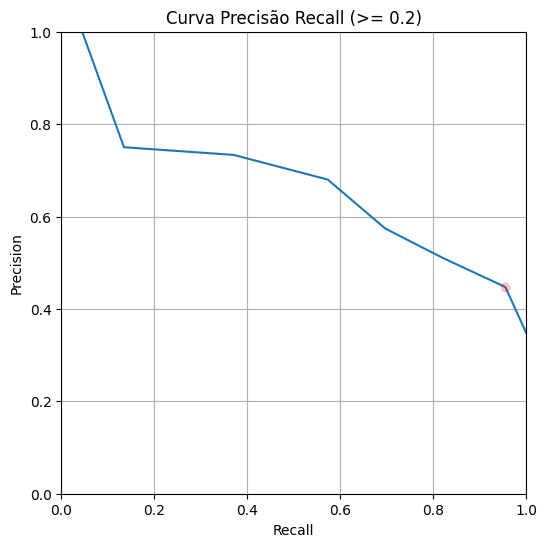


-----------------------------------------------------------------------
K-Neighbors:  11

Matriz de Confusão: 
[[145  22]
 [ 39  50]]


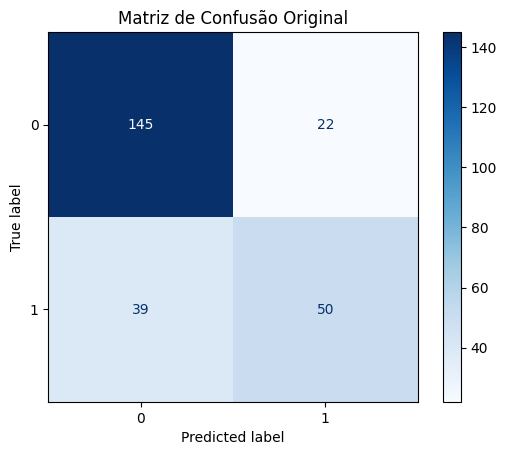


Acertos:  195  de  256
Erros:  61  de  256

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       167
           1       0.69      0.56      0.62        89

    accuracy                           0.76       256
   macro avg       0.74      0.72      0.72       256
weighted avg       0.76      0.76      0.75       256

-----------------------------------------------------------------------

Avaliação do modelo com threshold = 0.3

-----------------------------------------------------------------------
[[113  54]
 [ 22  67]]


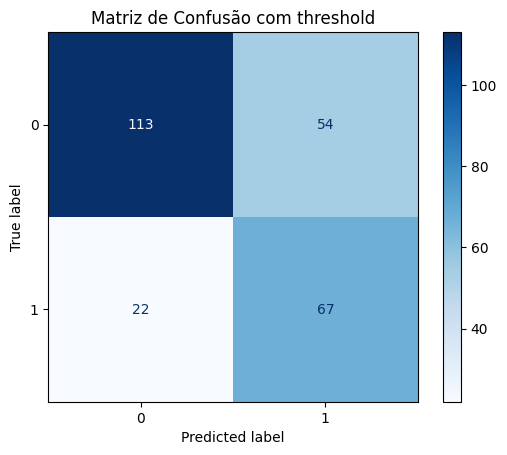

Relatório de Classificação com threshold
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       167
           1       0.55      0.75      0.64        89

    accuracy                           0.70       256
   macro avg       0.70      0.71      0.69       256
weighted avg       0.74      0.70      0.71       256



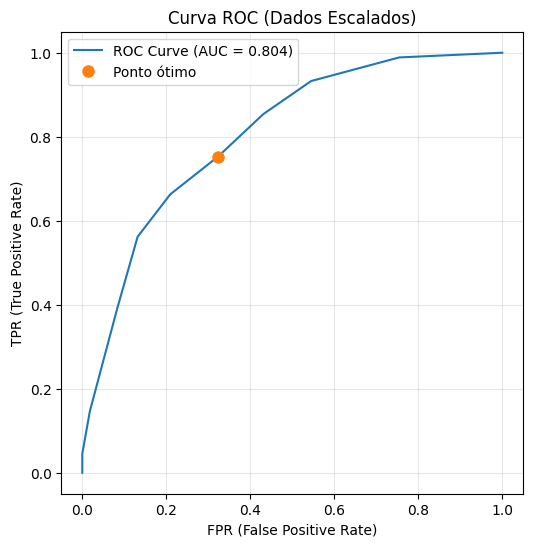

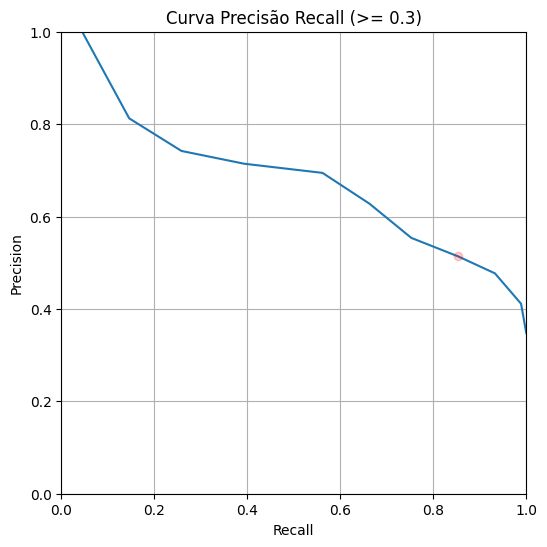

In [12]:
# Normalização dos dados
sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

for k in [3, 5, 7, 11]:
    print("\n-----------------------------------------------------------------------")

    print("K-Neighbors: ", k)
    kn = KNeighborsClassifier(n_neighbors=k)
    kn.fit(X_train_sc, y_train)

    ye = kn.predict(X_test_sc)

    MC = confusion_matrix(y_test, ye)
    print("\nMatriz de Confusão: ")
    print(MC)
    
    bkn = ConfusionMatrixDisplay(MC)
    bkn.plot(cmap='Blues'), plt.show
    plt.title('Matriz de Confusão Original')
    plt.show()

    # resultados
    print("\nAcertos: ", np.sum(y_test == ye), " de ", len(y_test))
    print("Erros: ", np.sum(y_test != ye), " de ", len(y_test))
    
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, ye))

    if k == 3:
        avaliacao(kn, X_test_sc, y_test, threshold=0.2)
    elif k == 5:
        avaliacao(kn, X_test_sc, y_test, threshold=0.3)
    elif k == 7:
        avaliacao(kn, X_test_sc, y_test, threshold=0.2)
    elif k == 11:
        avaliacao(kn, X_test_sc, y_test, threshold=0.3)

---

## Estudo Comparativo

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
resultados = {}

# MODELOS
modelos = [
    ('Logistic Regression', lr_scaled),
    ('Random Forest', rfc),
    ('K-Neighbors (k=5)', kn)
]

for nome, modelo in modelos:

    # Caso exceção para o Random Forest por que não usamos dados escalados
    if nome == 'Random Forest':
        X_test_model = X_test  # sem escala
    else:
        X_test_model = X_test_scaled  # com escala

    # Previsões
    y_pred = modelo.predict(X_test_scaled)  
    y_pred_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    
    resultados[nome] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba),
        'Previsão': y_pred,
        'Probabilidades': y_pred_proba
    }

print("\n---------------------------------------------------------------")
print("Estudo Comparativo dos Modelos")
print("---------------------------------------------------------------\n")

for nome, metricas in resultados.items():
    print("Modelo:", nome)
    print("  Accuracy :", round(metricas['Accuracy'], 4))
    print("  Precision:", round(metricas['Precision'], 4))
    print("  Recall   :", round(metricas['Recall'], 4))
    print("  F1-Score :", round(metricas['F1-Score'], 4))
    print("  AUC      :", round(metricas['AUC'], 4))
    print("----------------------------------------")



---------------------------------------------------------------
Estudo Comparativo dos Modelos
---------------------------------------------------------------

Modelo: Logistic Regression
  Accuracy : 0.7383
  Precision: 0.6486
  Recall   : 0.5393
  F1-Score : 0.589
  AUC      : 0.8286
----------------------------------------
Modelo: Random Forest
  Accuracy : 0.6523
  Precision: 0.0
  Recall   : 0.0
  F1-Score : 0.0
  AUC      : 0.5724
----------------------------------------
Modelo: K-Neighbors (k=5)
  Accuracy : 0.7617
  Precision: 0.6944
  Recall   : 0.5618
  F1-Score : 0.6211
  AUC      : 0.8042
----------------------------------------


C:\Users\migue\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
